In [0]:
#import dependancies
import torch,torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms,models
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

## Copy the following code and run the command to download the dataset
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

**Data Augmentation  **

In [0]:
train_transforms = transforms.Compose([
                                     transforms.RandomRotation(20),
                                     transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     
                                     transforms.ColorJitter(hue=.05, saturation=.05,brightness=.05),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                    transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])


**Data splitting and loading in mini batches**

In [0]:
num_workers=0
batch_size=32
valid_size=0.2

train_data=datasets.ImageFolder('flower_data/train',transform=train_transforms)
test_data=datasets.ImageFolder('flower_data/valid',transform=train_transforms)


num_train=len(train_data)
train_list=[i for i in range(num_train)]
split=train_list[int(valid_size*num_train)]
np.random.shuffle(train_list)
train_idx,valid_idx=train_list[split:],train_list[:split]

train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)


train_loader=torch.utils.data.DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)
valid_loader=torch.utils.data.DataLoader(train_data,sampler=valid_sampler,batch_size=batch_size)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size)

**If you get an error : no attribute named regular_extensions , copy the following code and restart the kernel**

from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

**Train Set Visualisation**

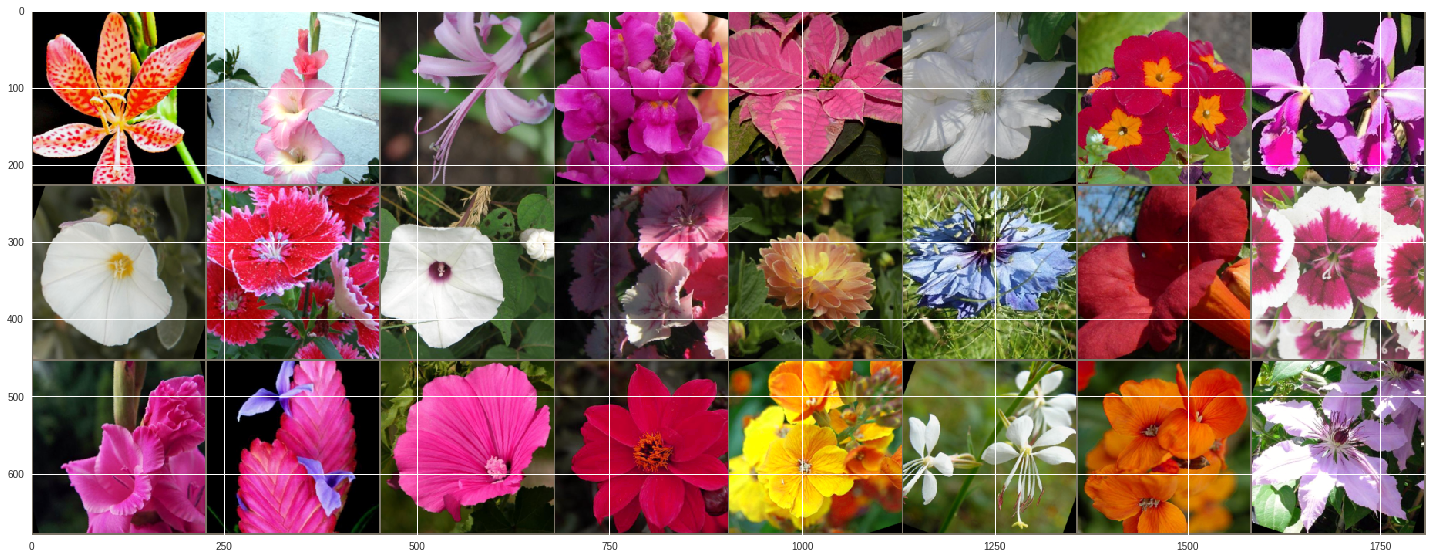

In [4]:

def imshow(img):
  plt.figure(figsize=(25,15))
  img=img.numpy()
  img[0,:,:]=img[0,:,:]*0.229+0.485
  img[1,:,:]=img[1,:,:]*0.224+0.456
  img[2,:,:]=img[2,:,:]*0.224+0.406
  plt.imshow(np.transpose(img,(1,2,0)))

images,labels=next(iter(train_loader))

img=torchvision.utils.make_grid(images[:24])
imshow(img)

**Test Set Visualisation**

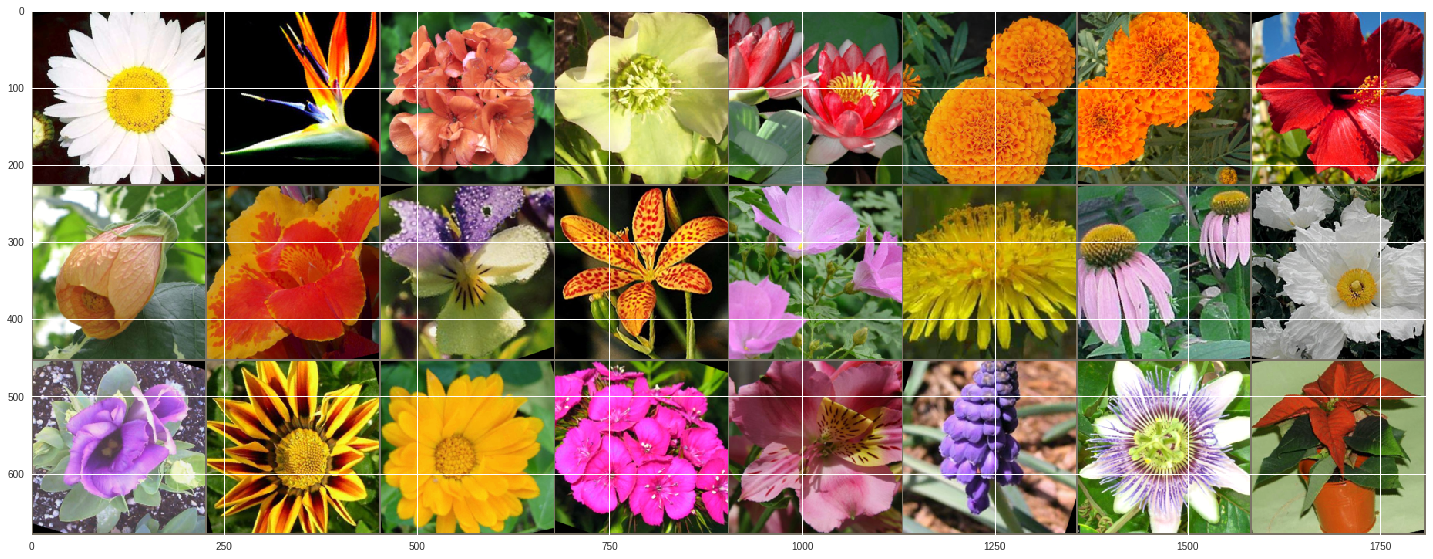

In [5]:
images,labels=next(iter(test_loader))

img=torchvision.utils.make_grid(images[:24])
imshow(img)

**Transfer Learning**
I have used densenet121 , You are free to chose yours

In [6]:
model=models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 62367097.08it/s]


**Adding the last fully connected layers to mould it according to our needs i.e 102 output categories and 1000 acc to imagenet on which the above model is trained**

In [0]:
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.25),
                                 nn.Linear(512, 102),
                                 nn.LogSoftmax(dim=1)) 
from timeit import default_timer as timer

**Un comment the below code and run it to make sure you are using gpu for computation**

In [0]:
# train_on_gpu=torch.cuda.is_available()

# if(train_on_gpu):
#     print('Training on GPU.')
# else:
#     print('No GPU available, training on CPU.')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device) 

In [0]:
for param in model.parameters():
    param.requires_grad = True        
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.parameters(),lr=0.00001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')          

In [0]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
scheduler.load_state_dict(checkpoint['optimizer_state_dict'])

In [78]:
n_epochs = 3

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    start=timer()
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    end=timer()
   

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            valid_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()
    valid_loss=valid_loss/len(valid_loader)
    scheduler.step(valid_loss)
    print("Epoch: {}/{}.. ".format(epoch, n_epochs),
          "Training Loss: {:.3f}.. ".format(train_loss/len(train_loader)),
          "validation Loss: {:.3f}.. ".format(valid_loss),
          "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
#     print('The time taken for epoch {}: {} minutes'.format((end-start)/60))
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model, 'checkpoint.pth')
        valid_loss_min = valid_loss

Epoch: 1/3..  Training Loss: 0.023..  validation Loss: 0.092..  Validation Accuracy: 0.973
Validation loss decreased (inf --> 0.091583).  Saving model ...
Epoch: 2/3..  Training Loss: 0.021..  validation Loss: 0.087..  Validation Accuracy: 0.974
Validation loss decreased (0.091583 --> 0.087443).  Saving model ...
Epoch: 3/3..  Training Loss: 0.020..  validation Loss: 0.091..  Validation Accuracy: 0.976


In [0]:
data_transforms = data_transforms = {
    'train': transforms.Compose([
             transforms.RandomRotation(20),
             transforms.Resize(255),
             transforms.CenterCrop(224),
             transforms.RandomHorizontalFlip(),

             transforms.ColorJitter(hue=.05, saturation=.05,brightness=.05),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406],
                                  [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
} 
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
model.class_to_idx = image_datasets['train'].class_to_idx

In [0]:
torch.save({
            'arch':'densenet121',
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': scheduler.state_dict(),
            'validation_accuraccy': '0.976',
            'epochs':'40',
            'class_to_idx': model.class_to_idx,
            'status': 'moving towards overfitting',
            'validation_loss': '0.091',
            'train_loss': '0.020',
            }, 'checkpoint.pth')

In [0]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])

In [81]:
with torch.no_grad():
    model.eval()
    accuracy=0.0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    print("Validation Accuracy: {:.3f}".format(accuracy/len(test_loader)))    

Validation Accuracy: 0.972


In [0]:
cat_to_name={"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}


In [0]:
data_dir = './flower_data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

dirs = {'train': train_dir, 
        'valid': valid_dir}

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax  

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    image_tensor.to('cpu')
    model_input.to('cpu')
    model.to('cpu')
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[2]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

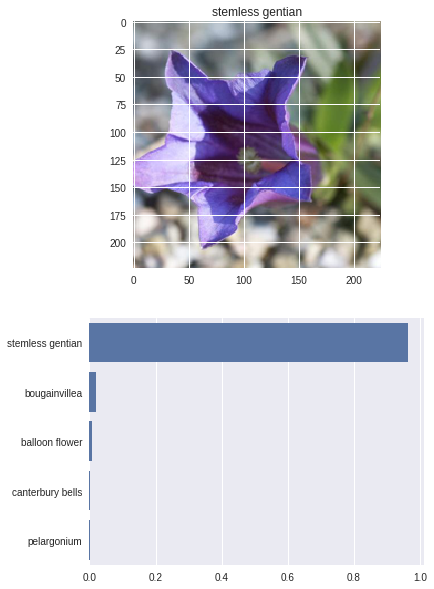

In [139]:
image_path='flower_data/valid/28/image_05267.jpg'
plot_solution(image_path, model)
